# Rabbani Nur Kumoro - 21/472599/PA/20310
# Deep Learning - CSB - The Second Assignment
# A Comparative Study of Overfitting Strategies in Multilayer Perceptrons

### 1. Import Libraries

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras import losses, optimizers, initializers
from keras.callbacks import ModelCheckpoint
from keras.datasets import fashion_mnist
from keras.initializers import he_normal
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, roc_auc_score, log_loss
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout, LeakyReLU

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

### 2. Data Acquisition

*Fashion MNIST* is a dataset from online fashion retailer *Zalando* consisting of a training set of 60,000 examples and a test set of 10,000 examples, where each example is a 28x28 grayscale image belonging to one of 10 possible classes (such as a t-shirt, dress, etc).

The class labels are as follows:

| Label | Description   | 
| ----- |:-------------:| 
| 0     | T-shirt/top   | 
| 1     | Trouser       |   
| 2     | Pullover      |  
| 3     | Dress         | 
| 4     | Coat          |   
| 5     | Sandal        | 
| 6     | Shirt         | 
| 7     | Sneaker       |   
| 8     | Bag           |  
| 9     | Ankle boot    |  

In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


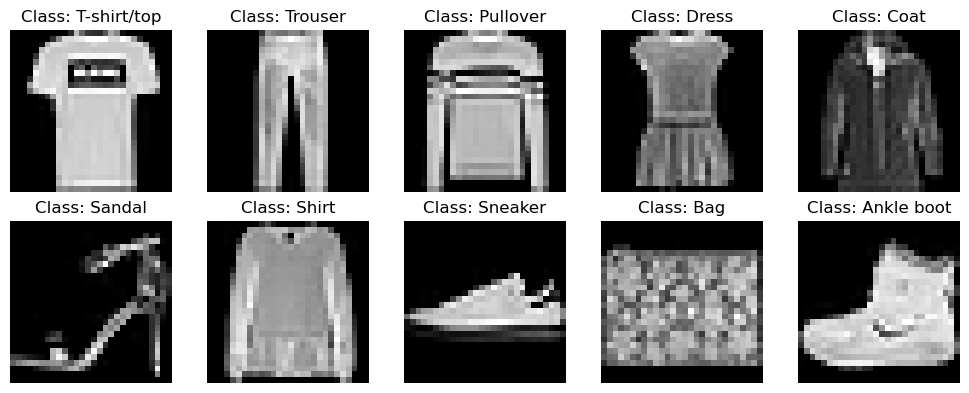

In [3]:
class_labels_dict = {0:"T-shirt/top",1:"Trouser",2:"Pullover",3:"Dress",4:"Coat",5:"Sandal",6:"Shirt",7:"Sneaker",8:"Bag",9:"Ankle boot"}

fig = plt.figure(figsize=(10,4))

for i in range(10):
    plt.subplot(2,5,i+1)
    img = X_train[y_train == i][0]
    plt.imshow(img, cmap='gray', interpolation='none')
    plt.title("Class: {}".format(class_labels_dict[i]))
    plt.axis('off')
    
plt.tight_layout()

### 3. Data Pre-Processing
The inputs to the MLP have to be single vectors rather than 2D images. As a result, it will have to reshape the input so that each 28x28 image becomes a single 784 dimensional vector. Unfortunately, this leads to some loss of information, as it becomes less clear which image pixels are next to each other.

In [4]:
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


Normalise the inputs so that pixel values are in the [0-1] range rather than [0-255].

In [5]:
X_train /= 255
X_test /= 255

At the moment, the target vectors `y_train` and `y_test` are represented as arrays which can take the values 0, 1, 2, etc. This means the MLP model would assume that predicting 1 instead of 0 is better than predicting 5. But the labels are actually categorical - the value 0 encodes t-shirts or tops, which are no more similar to trousers (encoded by 1) than they are to sandals (encoded by 5). To address this, **one-hot encoding** was used, a common technique for dealing with categorical variables.

One-hot encoding maps the classes in the following way:

`
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0] |
`
`
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0] |
`
`
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
`

In [6]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices using one-hot encoding
num_classes = 10 # There are 10 classes possible 
Y_train = to_categorical(y_train, num_classes)
Y_test = to_categorical(y_test, num_classes)

## 4. Experiments

### Default Model

- Number of Hidden Layers: 2
- The Number of Nodes in the Hidden Layer near the Input Layer: 512
- The Number of Nodes in the Hidden Layer near the Output Layer: 512
- Learning Rate: 0.001
- Weight Initialization: Xavier initialization

In [7]:
model_default = Sequential() # Declare a Sequential model 
model_default.add(Dense(512, input_shape=(784,))) # Add a dense input layer of 512 units
                                        # The input shape is (784,) because the features are 784 dimensional vectors
model_default.add(Activation('relu')) # Apply ReLu activation function to the layer output
model_default.add(Dense(512)) # Add a hidden layer of 512 units
model_default.add(Activation('relu'))
model_default.add(Dense(num_classes)) # Add an output layer of 10 units, the number of classes 
model_default.add(Activation('softmax')) # The "softmax" activation ensures the output is a valid probability distribution

model_default.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Metal device set to: Apple M1


2023-09-23 16:25:53.470880: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-23 16:25:53.470899: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
history_default = model_default.fit(X_train, 
                    Y_train,
                    batch_size=128, 
                    epochs=25,
                    verbose=1,
                    validation_data=(X_test,Y_test))

Epoch 1/25
  1/469 [..............................] - ETA: 2:13 - loss: 2.3711 - accuracy: 0.1250

2023-09-23 16:25:53.918821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - ETA: 0s - loss: 0.4783 - accuracy: 0.8283

2023-09-23 16:25:58.365000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 5s 10ms/step - loss: 0.4783 - accuracy: 0.8283 - val_loss: 0.3821 - val_accuracy: 0.8636
Epoch 2/25
469/469 [==============================] - 5s 10ms/step - loss: 0.3526 - accuracy: 0.8710 - val_loss: 0.3637 - val_accuracy: 0.8671
Epoch 3/25
469/469 [==============================] - 5s 11ms/step - loss: 0.3134 - accuracy: 0.8856 - val_loss: 0.3551 - val_accuracy: 0.8707
Epoch 4/25
469/469 [==============================] - 5s 10ms/step - loss: 0.2924 - accuracy: 0.8912 - val_loss: 0.3353 - val_accuracy: 0.8792
Epoch 5/25
469/469 [==============================] - 5s 11ms/step - loss: 0.2751 - accuracy: 0.8978 - val_loss: 0.3241 - val_accuracy: 0.8818
Epoch 6/25
469/469 [==============================] - 5s 11ms/step - loss: 0.2583 - accuracy: 0.9018 - val_loss: 0.3425 - val_accuracy: 0.8776
Epoch 7/25
469/469 [==============================] - 5s 10ms/step - loss: 0.2431 - accuracy: 0.9085 - val_loss: 0.3126 - val_accuracy: 0.8884
Epoch 8/25

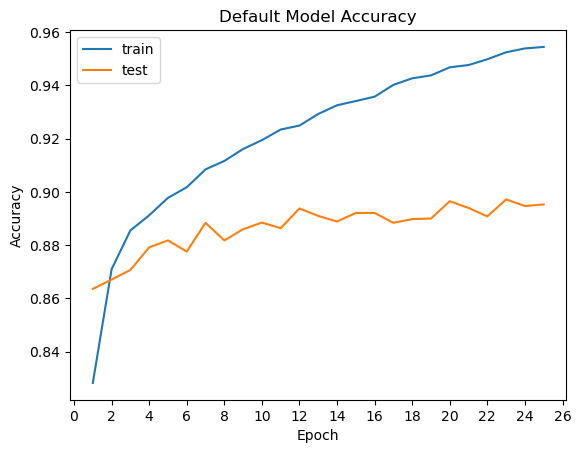

In [9]:
plt.plot(range(1,1+len(history_default.history['accuracy'])), history_default.history['accuracy'])
plt.plot(range(1,1+len(history_default.history['val_accuracy'])), history_default.history['val_accuracy'])
plt.title('Default Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.xticks(np.arange(0,28,2))
plt.show()

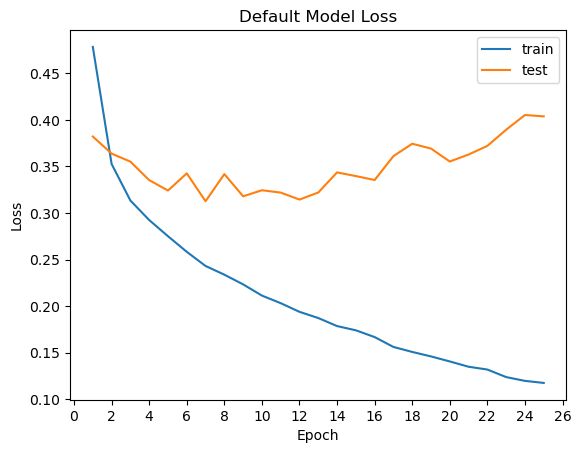

In [10]:
plt.plot(range(1,1+len(history_default.history['loss'])), history_default.history['loss'])
plt.plot(range(1,1+len(history_default.history['val_loss'])), history_default.history['val_loss'])
plt.title('Default Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.xticks(np.arange(0,28,2))
plt.show()

In [11]:
test_loss, test_acc = model_default.evaluate(X_test, Y_test, batch_size=128)

print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

79/79 [==============================] - 1s 7ms/step - loss: 0.4037 - accuracy: 0.8953
Test Accuracy: 0.8952999711036682
Test Loss: 0.40371400117874146


### a. Undersampling

In [12]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


In [13]:
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


In [14]:
X_train /= 255
X_test /= 255

In [15]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices using one-hot encoding
num_classes = 10 # There are 10 classes possible 
Y_train = to_categorical(y_train, num_classes)
Y_test = to_categorical(y_test, num_classes)

In [16]:
from imblearn.under_sampling import RandomUnderSampler

# Perform undersampling to balance the class distribution
sampler = RandomUnderSampler(sampling_strategy='majority')
X_train_resampled, Y_train_resampled = sampler.fit_resample(X_train, Y_train)

#### Model 1 - Undersampling

In [17]:
model_undersampling = Sequential() # Declare a Sequential model 
model_undersampling.add(Dense(512, input_shape=(784,))) # Add a dense input layer of 512 units
                                        # The input shape is (784,) because the features are 784 dimensional vectors
model_undersampling.add(Activation('relu')) # Apply ReLu activation function to the layer output
model_undersampling.add(Dense(512)) # Add a hidden layer of 512 units
model_undersampling.add(Activation('relu'))
model_undersampling.add(Dense(num_classes)) # Add an output layer of 10 units, the number of classes 
model_undersampling.add(Activation('softmax')) # The "softmax" activation ensures the output is a valid probability distribution

model_undersampling.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
history_undersampling = model_undersampling.fit(X_train_resampled, 
                    Y_train_resampled,
                    batch_size=128, 
                    epochs=25,
                    verbose=1,
                    validation_data=(X_test,Y_test))

Epoch 1/25
  4/469 [..............................] - ETA: 8s - loss: 1.8970 - accuracy: 0.3418  

2023-09-23 16:28:01.948630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - ETA: 0s - loss: 0.4749 - accuracy: 0.8303

2023-09-23 16:28:06.973803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 6s 12ms/step - loss: 0.4749 - accuracy: 0.8303 - val_loss: 0.4133 - val_accuracy: 0.8527
Epoch 2/25
469/469 [==============================] - 5s 11ms/step - loss: 0.3496 - accuracy: 0.8719 - val_loss: 0.3625 - val_accuracy: 0.8688
Epoch 3/25
469/469 [==============================] - 5s 10ms/step - loss: 0.3182 - accuracy: 0.8834 - val_loss: 0.3533 - val_accuracy: 0.8712
Epoch 4/25
469/469 [==============================] - 5s 10ms/step - loss: 0.2936 - accuracy: 0.8903 - val_loss: 0.3599 - val_accuracy: 0.8717
Epoch 5/25
469/469 [==============================] - 5s 10ms/step - loss: 0.2748 - accuracy: 0.8981 - val_loss: 0.3401 - val_accuracy: 0.8778
Epoch 6/25
469/469 [==============================] - 5s 10ms/step - loss: 0.2558 - accuracy: 0.9045 - val_loss: 0.3322 - val_accuracy: 0.8845
Epoch 7/25
469/469 [==============================] - 5s 10ms/step - loss: 0.2440 - accuracy: 0.9074 - val_loss: 0.3438 - val_accuracy: 0.8772
Epoch 8/25

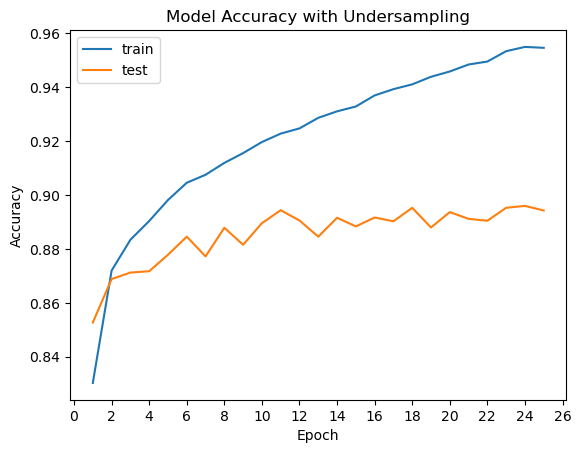

In [19]:
plt.plot(range(1,1+len(history_undersampling.history['accuracy'])), history_undersampling.history['accuracy'])
plt.plot(range(1,1+len(history_undersampling.history['val_accuracy'])), history_undersampling.history['val_accuracy'])
plt.title('Model Accuracy with Undersampling')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.xticks(np.arange(0,28,2))
plt.show()

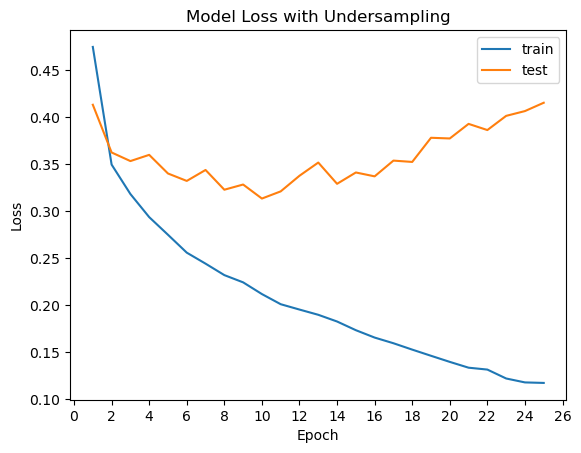

In [20]:
plt.plot(range(1,1+len(history_undersampling.history['loss'])), history_undersampling.history['loss'])
plt.plot(range(1,1+len(history_undersampling.history['val_loss'])), history_undersampling.history['val_loss'])
plt.title('Model Loss with Undersampling')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.xticks(np.arange(0,28,2))
plt.show()

In [21]:
test_loss, test_acc = model_undersampling.evaluate(X_test, Y_test, batch_size=128)

print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

79/79 [==============================] - 1s 9ms/step - loss: 0.4154 - accuracy: 0.8942
Test Accuracy: 0.8942000269889832
Test Loss: 0.41543832421302795


### b. Feature Selection

In [22]:
from sklearn.feature_selection import SelectKBest, chi2
from keras.datasets import fashion_mnist
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import to_categorical

In [23]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


In [24]:
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


In [25]:
X_train /= 255
X_test /= 255

In [26]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices using one-hot encoding
num_classes = 10 # There are 10 classes possible 
Y_train = to_categorical(y_train, num_classes)
Y_test = to_categorical(y_test, num_classes)

In [27]:
# Perform feature selection using SelectKBest and chi-squared scoring
k_best_features = 100  # Choose the number of top features to select
selector = SelectKBest(score_func=chi2, k=k_best_features)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

#### Model 2 - Feature Selection

In [28]:
model_feature_selection = Sequential() # Declare a Sequential model 
model_feature_selection.add(Dense(512, input_shape=(k_best_features,))) # Input shape should be (k_best_features,)
model_feature_selection.add(Activation('relu')) # Apply ReLu activation function to the layer output
model_feature_selection.add(Dense(512)) # Add a hidden layer of 512 units
model_feature_selection.add(Activation('relu'))
model_feature_selection.add(Dense(num_classes)) # Add an output layer of 10 units, the number of classes 
model_feature_selection.add(Activation('softmax')) # The "softmax" activation ensures the output is a valid probability distribution

model_feature_selection.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
history_feature_selection = model_feature_selection.fit(X_train_selected, 
                    Y_train,
                    batch_size=128, 
                    epochs=25,
                    verbose=1,
                    validation_data=(X_test_selected, Y_test))

Epoch 1/25
  6/469 [..............................] - ETA: 5s - loss: 1.9168 - accuracy: 0.3398  

2023-09-23 16:30:10.088944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - ETA: 0s - loss: 0.6534 - accuracy: 0.7636

2023-09-23 16:30:14.699969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 5s 11ms/step - loss: 0.6534 - accuracy: 0.7636 - val_loss: 0.5600 - val_accuracy: 0.7919
Epoch 2/25
469/469 [==============================] - 5s 11ms/step - loss: 0.5242 - accuracy: 0.8065 - val_loss: 0.5369 - val_accuracy: 0.8034
Epoch 3/25
469/469 [==============================] - 5s 11ms/step - loss: 0.4892 - accuracy: 0.8178 - val_loss: 0.5148 - val_accuracy: 0.8077
Epoch 4/25
469/469 [==============================] - 5s 11ms/step - loss: 0.4667 - accuracy: 0.8260 - val_loss: 0.4991 - val_accuracy: 0.8131
Epoch 5/25
469/469 [==============================] - 5s 11ms/step - loss: 0.4476 - accuracy: 0.8324 - val_loss: 0.5086 - val_accuracy: 0.8100
Epoch 6/25
469/469 [==============================] - 5s 11ms/step - loss: 0.4330 - accuracy: 0.8386 - val_loss: 0.4825 - val_accuracy: 0.8219
Epoch 7/25
469/469 [==============================] - 5s 11ms/step - loss: 0.4184 - accuracy: 0.8428 - val_loss: 0.4748 - val_accuracy: 0.8252
Epoch 8/25

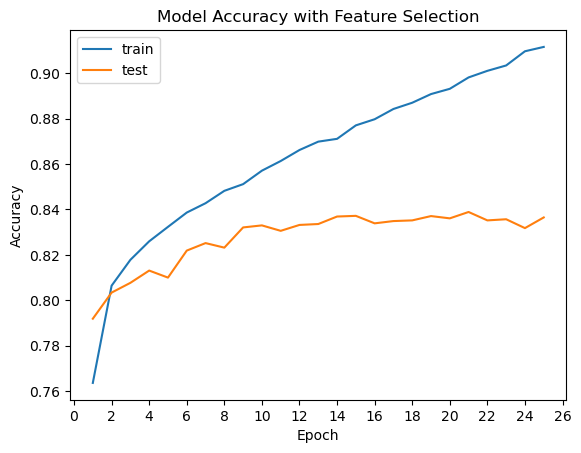

In [30]:
plt.plot(range(1,1+len(history_feature_selection.history['accuracy'])), history_feature_selection.history['accuracy'])
plt.plot(range(1,1+len(history_feature_selection.history['val_accuracy'])), history_feature_selection.history['val_accuracy'])
plt.title('Model Accuracy with Feature Selection')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.xticks(np.arange(0,28,2))
plt.show()

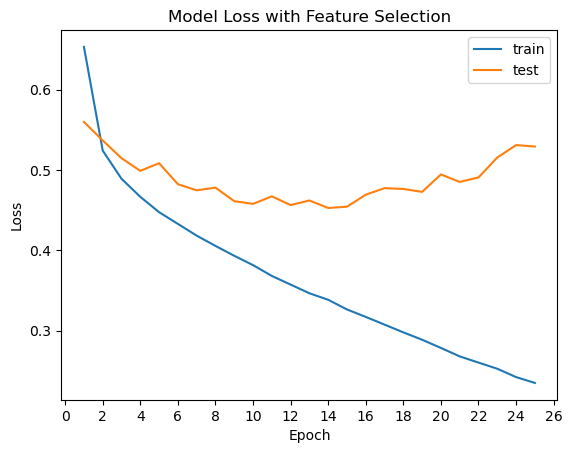

In [31]:
plt.plot(range(1,1+len(history_feature_selection.history['loss'])), history_feature_selection.history['loss'])
plt.plot(range(1,1+len(history_feature_selection.history['val_loss'])), history_feature_selection.history['val_loss'])
plt.title('Model Loss with Feature Selection')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.xticks(np.arange(0,28,2))
plt.show()

In [32]:
test_loss, test_acc = model_feature_selection.evaluate(X_test_selected, Y_test, batch_size=128)

print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

79/79 [==============================] - 1s 8ms/step - loss: 0.5294 - accuracy: 0.8365
Test Accuracy: 0.8364999890327454
Test Loss: 0.5293843150138855


### c. Data Transform

In [33]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import to_categorical
from keras.datasets import fashion_mnist
import numpy as np

In [34]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


In [35]:
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


In [36]:
X_train /= 255
X_test /= 255

In [37]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices using one-hot encoding
num_classes = 10 # There are 10 classes possible 
Y_train = to_categorical(y_train, num_classes)
Y_test = to_categorical(y_test, num_classes)

In [38]:
# Apply log transformation to the input data
X_train_log_transformed = np.log1p(X_train)  # Adding 1 to avoid log(0)
X_test_log_transformed = np.log1p(X_test)

#### Model 3 - Data Transformation

In [40]:
model_data_transformation = Sequential() # Declare a Sequential model 
model_data_transformation.add(Dense(512, input_shape=(784,))) # Input shape should match the number of retained components
model_data_transformation.add(Activation('relu')) # Apply ReLu activation function to the layer output
model_data_transformation.add(Dense(512)) # Add a hidden layer of 512 units
model_data_transformation.add(Activation('relu'))
model_data_transformation.add(Dense(num_classes)) # Add an output layer of 10 units, the number of classes 
model_data_transformation.add(Activation('softmax')) # The "softmax" activation ensures the output is a valid probability distribution

model_data_transformation.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [41]:
history_data_transformation = model_data_transformation.fit(X_train_log_transformed, 
                    Y_train,
                    batch_size=128, 
                    epochs=25,
                    verbose=1,
                    validation_data=(X_test_log_transformed, Y_test))

Epoch 1/25
 11/469 [..............................] - ETA: 4s - loss: 1.3341 - accuracy: 0.5597

2023-09-23 16:33:42.845858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


466/469 [============================>.] - ETA: 0s - loss: 0.4784 - accuracy: 0.8286

2023-09-23 16:33:47.302905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 5s 11ms/step - loss: 0.4775 - accuracy: 0.8289 - val_loss: 0.4167 - val_accuracy: 0.8485
Epoch 2/25
469/469 [==============================] - 5s 10ms/step - loss: 0.3513 - accuracy: 0.8702 - val_loss: 0.3564 - val_accuracy: 0.8684
Epoch 3/25
469/469 [==============================] - 5s 10ms/step - loss: 0.3148 - accuracy: 0.8833 - val_loss: 0.3391 - val_accuracy: 0.8759
Epoch 4/25
469/469 [==============================] - 5s 10ms/step - loss: 0.2920 - accuracy: 0.8906 - val_loss: 0.3663 - val_accuracy: 0.8682
Epoch 5/25
469/469 [==============================] - 5s 10ms/step - loss: 0.2775 - accuracy: 0.8957 - val_loss: 0.3327 - val_accuracy: 0.8828
Epoch 6/25
469/469 [==============================] - 5s 10ms/step - loss: 0.2608 - accuracy: 0.9028 - val_loss: 0.3199 - val_accuracy: 0.8848
Epoch 7/25
469/469 [==============================] - 6s 12ms/step - loss: 0.2474 - accuracy: 0.9065 - val_loss: 0.3304 - val_accuracy: 0.8833
Epoch 8/25

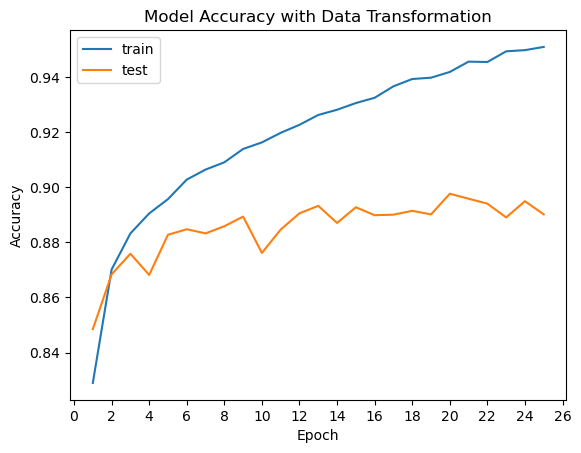

In [42]:
plt.plot(range(1,1+len(history_data_transformation.history['accuracy'])), history_data_transformation.history['accuracy'])
plt.plot(range(1,1+len(history_data_transformation.history['val_accuracy'])), history_data_transformation.history['val_accuracy'])
plt.title('Model Accuracy with Data Transformation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.xticks(np.arange(0,28,2))
plt.show()

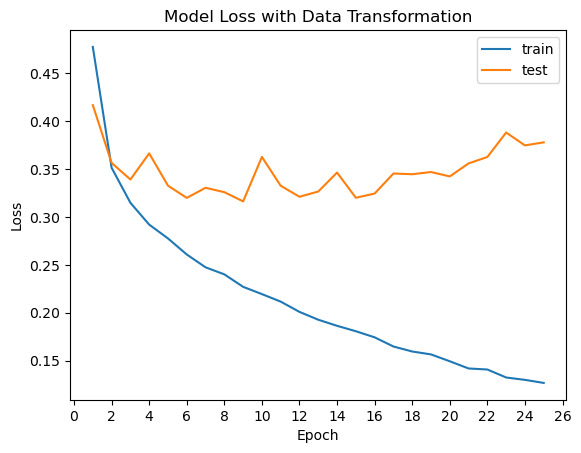

In [43]:
plt.plot(range(1,1+len(history_data_transformation.history['loss'])), history_data_transformation.history['loss'])
plt.plot(range(1,1+len(history_data_transformation.history['val_loss'])), history_data_transformation.history['val_loss'])
plt.title('Model Loss with Data Transformation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.xticks(np.arange(0,28,2))
plt.show()

In [44]:
test_loss, test_acc = model_data_transformation.evaluate(X_test_log_transformed, Y_test, batch_size=128)

print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

79/79 [==============================] - 1s 8ms/step - loss: 0.3779 - accuracy: 0.8902
Test Accuracy: 0.8902000188827515
Test Loss: 0.3778623640537262


### d. Dropout Layers

In [45]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import to_categorical
from keras.datasets import fashion_mnist

In [46]:
# Load the Fashion MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


In [47]:
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


In [48]:
X_train /= 255
X_test /= 255

In [49]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices using one-hot encoding
num_classes = 10 # There are 10 classes possible 
Y_train = to_categorical(y_train, num_classes)
Y_test = to_categorical(y_test, num_classes)

#### Model 4 - Dropout Layers

In [50]:
# Define the model with Dropout layers
model_dropout = Sequential()
model_dropout.add(Dense(512, input_shape=(784,)))
model_dropout.add(Activation('relu'))

# Add a Dropout layer with a specified dropout rate (e.g., 0.2)
model_dropout.add(Dropout(0.2))

model_dropout.add(Dense(512))
model_dropout.add(Activation('relu'))

# Add another Dropout layer
model_dropout.add(Dropout(0.2))

model_dropout.add(Dense(num_classes))
model_dropout.add(Activation('softmax'))

# Compile the model
model_dropout.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
history_dropout = model_dropout.fit(X_train, 
                    Y_train,
                    batch_size=128, 
                    epochs=25,
                    verbose=1,
                    validation_data=(X_test, Y_test))

Epoch 1/25
  6/469 [..............................] - ETA: 5s - loss: 1.7221 - accuracy: 0.4271  

2023-09-23 16:35:48.374109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - ETA: 0s - loss: 0.5093 - accuracy: 0.8172

2023-09-23 16:35:53.367727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 6s 12ms/step - loss: 0.5093 - accuracy: 0.8172 - val_loss: 0.4037 - val_accuracy: 0.8556
Epoch 2/25
469/469 [==============================] - 6s 12ms/step - loss: 0.3785 - accuracy: 0.8620 - val_loss: 0.3706 - val_accuracy: 0.8652
Epoch 3/25
469/469 [==============================] - 6s 12ms/step - loss: 0.3420 - accuracy: 0.8741 - val_loss: 0.3699 - val_accuracy: 0.8653
Epoch 4/25
469/469 [==============================] - 5s 11ms/step - loss: 0.3204 - accuracy: 0.8819 - val_loss: 0.3674 - val_accuracy: 0.8639
Epoch 5/25
469/469 [==============================] - 5s 11ms/step - loss: 0.3068 - accuracy: 0.8862 - val_loss: 0.3484 - val_accuracy: 0.8734
Epoch 6/25
469/469 [==============================] - 5s 11ms/step - loss: 0.2920 - accuracy: 0.8905 - val_loss: 0.3444 - val_accuracy: 0.8778
Epoch 7/25
469/469 [==============================] - 6s 12ms/step - loss: 0.2824 - accuracy: 0.8943 - val_loss: 0.3247 - val_accuracy: 0.8823
Epoch 8/25

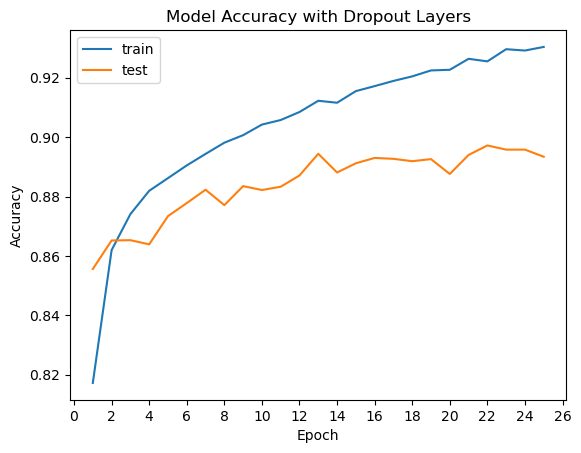

In [52]:
plt.plot(range(1,1+len(history_dropout.history['accuracy'])), history_dropout.history['accuracy'])
plt.plot(range(1,1+len(history_dropout.history['val_accuracy'])), history_dropout.history['val_accuracy'])
plt.title('Model Accuracy with Dropout Layers')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.xticks(np.arange(0,28,2))
plt.show()

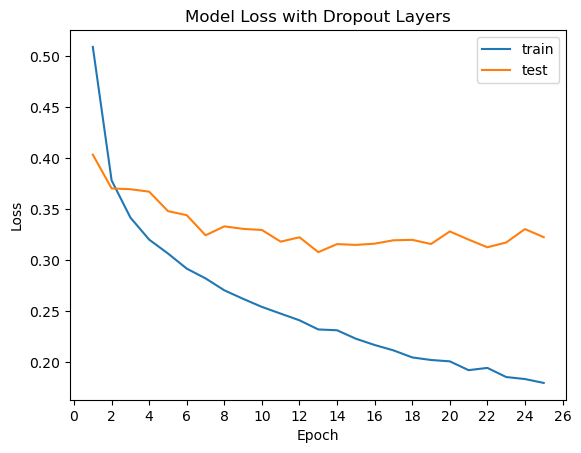

In [53]:
plt.plot(range(1,1+len(history_dropout.history['loss'])), history_dropout.history['loss'])
plt.plot(range(1,1+len(history_dropout.history['val_loss'])), history_dropout.history['val_loss'])
plt.title('Model Loss with Dropout Layers')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.xticks(np.arange(0,28,2))
plt.show()

In [54]:
test_loss, test_acc = model_dropout.evaluate(X_test, Y_test, batch_size=128)

print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

79/79 [==============================] - 1s 8ms/step - loss: 0.3228 - accuracy: 0.8934
Test Accuracy: 0.8934000134468079
Test Loss: 0.3228085935115814


### e. Regularization

#### Model 5 - L2 Regularization

In [55]:
from keras.regularizers import l2  # Import L2 regularization

# Define the model with L2 regularization
model_regularization = Sequential()

# Add a Dense layer with L2 regularization
model_regularization.add(Dense(512, input_shape=(784,), kernel_regularizer=l2(0.01)))  # Add L2 regularization with a specified lambda (0.01 in this example)
model_regularization.add(Activation('relu'))

# Add another Dense layer with L2 regularization
model_regularization.add(Dense(512, kernel_regularizer=l2(0.01)))
model_regularization.add(Activation('relu'))

model_regularization.add(Dense(num_classes))
model_regularization.add(Activation('softmax'))

# Compile the model
model_regularization.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [56]:
history_regularization = model_regularization.fit(X_train, 
                    Y_train,
                    batch_size=128, 
                    epochs=25,
                    verbose=1,
                    validation_data=(X_test, Y_test))

Epoch 1/25
  5/469 [..............................] - ETA: 7s - loss: 12.4808 - accuracy: 0.4859  

2023-09-23 16:37:59.871288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - ETA: 0s - loss: 1.8103 - accuracy: 0.7924

2023-09-23 16:38:06.172611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 7s 15ms/step - loss: 1.8103 - accuracy: 0.7924 - val_loss: 0.7495 - val_accuracy: 0.7984
Epoch 2/25
469/469 [==============================] - 7s 14ms/step - loss: 0.6906 - accuracy: 0.8191 - val_loss: 0.6809 - val_accuracy: 0.8131
Epoch 3/25
469/469 [==============================] - 7s 14ms/step - loss: 0.6408 - accuracy: 0.8274 - val_loss: 0.6282 - val_accuracy: 0.8263
Epoch 4/25
469/469 [==============================] - 7s 15ms/step - loss: 0.6094 - accuracy: 0.8335 - val_loss: 0.6437 - val_accuracy: 0.8121
Epoch 5/25
469/469 [==============================] - 8s 17ms/step - loss: 0.5836 - accuracy: 0.8394 - val_loss: 0.5921 - val_accuracy: 0.8351
Epoch 6/25
469/469 [==============================] - 7s 15ms/step - loss: 0.5668 - accuracy: 0.8426 - val_loss: 0.5747 - val_accuracy: 0.8386
Epoch 7/25
469/469 [==============================] - 7s 15ms/step - loss: 0.5502 - accuracy: 0.8474 - val_loss: 0.5848 - val_accuracy: 0.8347
Epoch 8/25

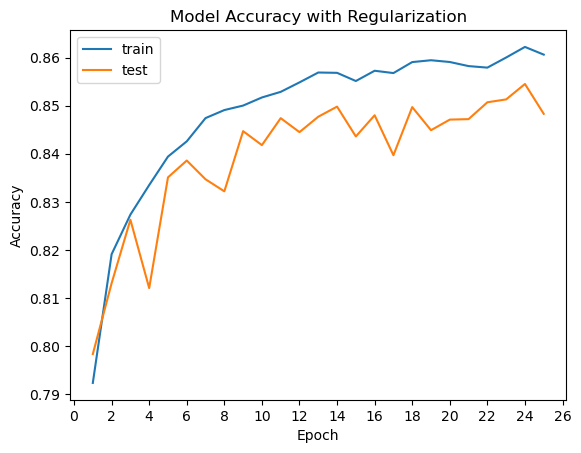

In [57]:
plt.plot(range(1,1+len(history_regularization.history['accuracy'])), history_regularization.history['accuracy'])
plt.plot(range(1,1+len(history_regularization.history['val_accuracy'])), history_regularization.history['val_accuracy'])
plt.title('Model Accuracy with Regularization')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.xticks(np.arange(0,28,2))
plt.show()

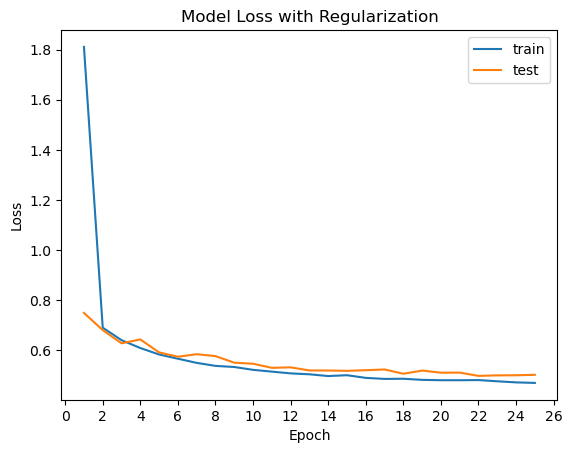

In [58]:
plt.plot(range(1,1+len(history_regularization.history['loss'])), history_regularization.history['loss'])
plt.plot(range(1,1+len(history_regularization.history['val_loss'])), history_regularization.history['val_loss'])
plt.title('Model Loss with Regularization')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.xticks(np.arange(0,28,2))
plt.show()

In [59]:
test_loss, test_acc = model_regularization.evaluate(X_test, Y_test, batch_size=128)

print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

79/79 [==============================] - 1s 11ms/step - loss: 0.5026 - accuracy: 0.8483
Test Accuracy: 0.8482999801635742
Test Loss: 0.5025861859321594


### f. Early Stopping

#### Model 6 - Early Stopping

In [60]:
# Define the model with Dropout layers
model_early_stopping = Sequential()
model_early_stopping.add(Dense(512, input_shape=(784,)))
model_early_stopping.add(Activation('relu'))
model_early_stopping.add(Dense(512))
model_early_stopping.add(Activation('relu'))
model_early_stopping.add(Dense(num_classes))
model_early_stopping.add(Activation('softmax'))

# Compile the model
model_early_stopping.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [61]:
from keras.callbacks import EarlyStopping  # Import EarlyStopping callback

# Define EarlyStopping callback to monitor validation loss and stop when it stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [62]:
history_early_stopping = model_early_stopping.fit(X_train, 
                    Y_train,
                    batch_size=128, 
                    epochs=25,
                    verbose=1,
                    validation_data=(X_test, Y_test),
                    callbacks=[early_stopping])

Epoch 1/25
  6/469 [..............................] - ETA: 5s - loss: 1.6397 - accuracy: 0.4596  

2023-09-23 16:41:01.283895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - ETA: 0s - loss: 0.4796 - accuracy: 0.8266

2023-09-23 16:41:06.444650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 6s 12ms/step - loss: 0.4796 - accuracy: 0.8266 - val_loss: 0.4140 - val_accuracy: 0.8473
Epoch 2/25
469/469 [==============================] - 5s 12ms/step - loss: 0.3557 - accuracy: 0.8696 - val_loss: 0.3800 - val_accuracy: 0.8599
Epoch 3/25
469/469 [==============================] - 5s 11ms/step - loss: 0.3172 - accuracy: 0.8818 - val_loss: 0.3420 - val_accuracy: 0.8759
Epoch 4/25
469/469 [==============================] - 5s 11ms/step - loss: 0.2900 - accuracy: 0.8914 - val_loss: 0.3385 - val_accuracy: 0.8769
Epoch 5/25
469/469 [==============================] - 6s 13ms/step - loss: 0.2739 - accuracy: 0.8985 - val_loss: 0.3664 - val_accuracy: 0.8670
Epoch 6/25
469/469 [==============================] - 5s 12ms/step - loss: 0.2596 - accuracy: 0.9021 - val_loss: 0.3296 - val_accuracy: 0.8817
Epoch 7/25
469/469 [==============================] - 5s 11ms/step - loss: 0.2486 - accuracy: 0.9064 - val_loss: 0.3368 - val_accuracy: 0.8775
Epoch 8/25

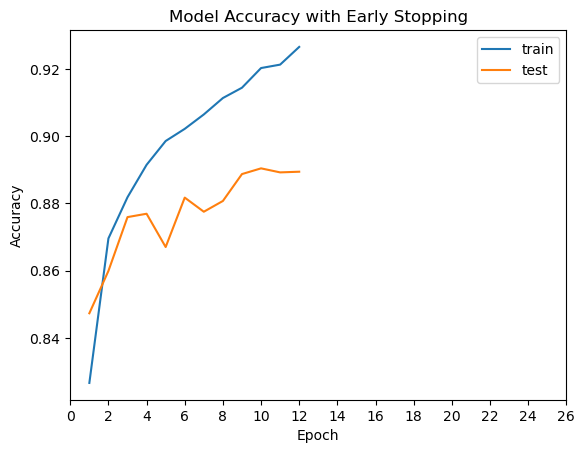

In [63]:
plt.plot(range(1,1+len(history_early_stopping.history['accuracy'])), history_early_stopping.history['accuracy'])
plt.plot(range(1,1+len(history_early_stopping.history['val_accuracy'])), history_early_stopping.history['val_accuracy'])
plt.title('Model Accuracy with Early Stopping')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.xticks(np.arange(0,28,2))
plt.show()

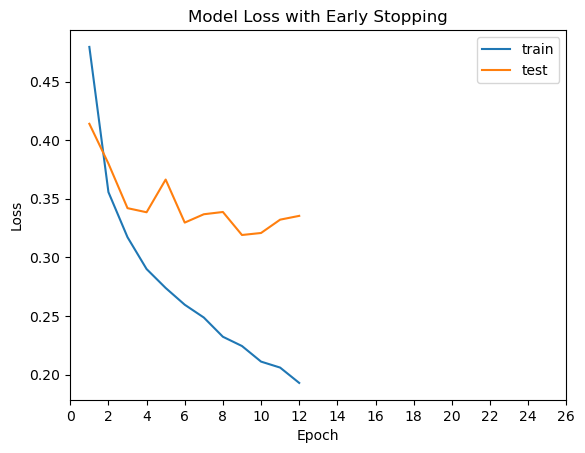

In [64]:
plt.plot(range(1,1+len(history_early_stopping.history['loss'])), history_early_stopping.history['loss'])
plt.plot(range(1,1+len(history_early_stopping.history['val_loss'])), history_early_stopping.history['val_loss'])
plt.title('Model Loss with Early Stopping')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.xticks(np.arange(0,28,2))
plt.show()

In [65]:
test_loss, test_acc = model_early_stopping.evaluate(X_test, Y_test, batch_size=128)

print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

79/79 [==============================] - 1s 8ms/step - loss: 0.3191 - accuracy: 0.8887
Test Accuracy: 0.888700008392334
Test Loss: 0.31906527280807495
